# Initialize Packages & DB

In [ ]:
%reload_ext sql
%run lib.py

%sql postgresql+psycopg2://postgres:@127.0.0.1:5432/fcrec

# Create User Profile - Word and Entity Weights

In [ ]:
%%sql
drop table if exists mind_train_user_word_w;

create table mind_train_user_word_w as
with user_word_w as (
select a.user_id, b.word, sum(w) w
from mind_train_user_history a
	join mind_train_news_word_w b on b.news_id = a.news_id
group by a.user_id, b.word )
select user_id, word, w / sqrt(sum(pow(w, 2)) over (partition by user_id)) w
from user_word_w;

create index idx_mind_train_user_word_w_1 on mind_train_user_word_w (user_id, word, w);

drop table if exists mind_train_user_entity_w;

create table mind_train_user_entity_w as
with user_entity_w as (
select a.user_id, b.label, sum(w) w
from mind_train_user_history a
	join mind_train_news_entity_w b on b.news_id = a.news_id
group by a.user_id, b.label )
select user_id, label, w / sqrt(sum(pow(w, 2)) over (partition by user_id)) w
from user_entity_w;

create index idx_mind_train_user_entity_w_1 on mind_train_user_entity_w (user_id, label, w);

# Check User History and Profile

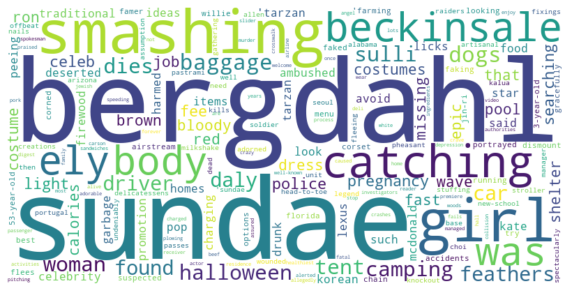

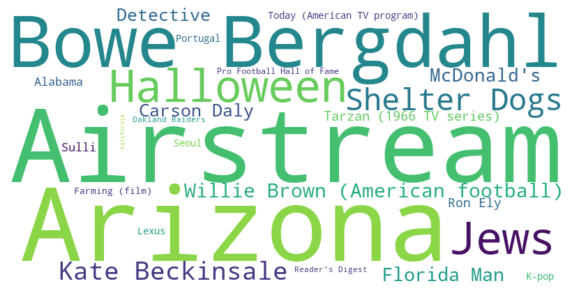

In [ ]:
user_id = 'U89675'

show_user_history_news(user_id, size=8)

user_profile = get_user_profile(user_id)

show_wordcloud(create_wordcloud(user_profile['word_vec']))

show_wordcloud(create_wordcloud(user_profile['entity_vec']))

# Recommend News

In [ ]:
size = 20

query = f'''
    with rec as (
        select b.news_id, sum(a.w*b.w) sim
        from mind_train_user_word_w a
            join mind_train_news_word_w b on b.word = a.word
        where a.user_id = '{user_id}'
        group by b.news_id
        union all 
        select b.news_id, sum(a.w*b.w) sim
        from mind_train_user_entity_w a
            join mind_train_news_entity_w b on b.label = a.label
        where a.user_id = '{user_id}'
        group by b.news_id )
    select t.sim, s.id, s.category1, s.category2, s.title, s.abstract, s.url
    from (
        select news_id, sum(sim) sim
        from rec
        group by news_id
        order by sim desc
        limit {size} ) t
        join mind_train_news s on s.id = t.news_id
    order by t.sim desc;
    '''